In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import sys
import time
from IPython.display import display, clear_output
np.set_printoptions(threshold=sys.maxsize)
# from matplotlib import animation as ani

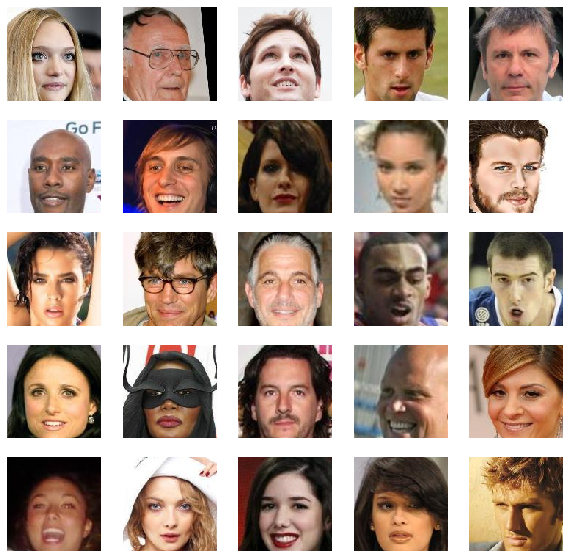

In [2]:
with open('CelebA16000_rand.bin','rb') as face:
    face = np.fromfile(face,dtype='uint8',count=-1)
    face = face.reshape(1,-1)
    face = np.transpose(face,[0,1])
    face = face.reshape(-1,218,3,178).transpose([0,1,3,2]) # imsize = [-1,218,178,3]
    face = face[:,45:173,25:153,:]/255
    
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(face[np.random.randint(0,face.shape[0]),:,:,:],cmap='viridis')

In [3]:
initial_lr = 0.0001
minimum_lr = 0.00001
lr_decay_rate = 0.9
lr_decay_step = 0

lamb = 0.001
epoch = 200
kt = 0
gamma = 0.5
lat_size=512

batch_size = 16
num_batch = int(face.shape[0]/batch_size)

In [4]:
# tf.keras.backend.set_floatx('float64')

def make_disc():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'elu'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'elu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='VALID'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'elu'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'elu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='VALID'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'elu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'elu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='VALID'))
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'elu'))
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'elu'))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096))
    model.add(tf.keras.layers.Reshape((16,16,16)))

    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.UpSampling2D(size=(2, 2),interpolation='nearest'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.UpSampling2D(size=(2, 2),interpolation='nearest'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.UpSampling2D(size=(2, 2),interpolation='nearest'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    
    model.add(tf.keras.layers.Conv2D(filters = 3, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'linear'))
    
    return model

def make_gen():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(4096))
    model.add(tf.keras.layers.Reshape((16,16,16)))

    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.UpSampling2D(size=(2, 2),interpolation='nearest'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.UpSampling2D(size=(2, 2),interpolation='nearest'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.UpSampling2D(size=(2, 2),interpolation='nearest'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation='elu'))
    
    model.add(tf.keras.layers.Conv2D(filters = 3, kernel_size=[3,3], strides=(1, 1), padding='SAME', activation = 'linear'))
    
    return model

In [5]:
generator = make_gen()
discriminator = make_disc()

generator_optimizer = tf.keras.optimizers.Adam(initial_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(initial_lr)

# fig = plt.figure()
# ax1 = fig.add_subplot(1,1,1)

kttot = [kt]
Mtot = []
Dlossmat = []
Glossmat = []
lrmat = []
lr = initial_lr
M = np.Inf

for e in range(epoch):
    Z = np.random.uniform(low=-1,high=1,size=[face.shape[0],lat_size])

    index_order= np.arange(face.shape[0])
    np.random.shuffle(index_order)
    
    if M < np.average(Mtot):
        lr_decay_step += 1
        lr = max(initial_lr*(lr_decay_rate**lr_decay_step),minimum_lr)        
        generator_optimizer = tf.keras.optimizers.Adam(lr)
        discriminator_optimizer = tf.keras.optimizers.Adam(lr)        

    for b in range(num_batch):
        index_list = index_order[b*batch_size:(b+1)*batch_size]
        latent = Z[index_list,:]
        data_batch = face[index_list,:,:,:]
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_latent = generator(latent,training=False)
            
            cat_for_train = tf.concat([data_batch,gen_latent],axis=0)
            
            D_cat_out = discriminator(cat_for_train,training=True)
            D_real_out,D_fake_out = tf.split(D_cat_out,2)
            Dloss_real = tf.math.reduce_mean(tf.abs(data_batch-D_real_out))
            Dloss_fake = tf.math.reduce_mean(tf.abs(gen_latent-D_fake_out))
            Dloss = Dloss_real - kt*Dloss_fake
            
            gradients_of_discriminator = disc_tape.gradient(Dloss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            
            gen_latent = generator(latent,training=True)
        
            Gloss = tf.math.reduce_mean(abs(gen_latent-discriminator(gen_latent,training=False)))
            
            gradients_of_generator = gen_tape.gradient(Gloss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            
        kt=tf.clip_by_value(kt+lamb*(gamma*Dloss_real-Gloss),0,1)
        kttot = np.append(kttot,[kt],axis=0)

        M = Dloss_real + np.abs(gamma*Dloss_real - Gloss)
        Mtot = np.append(Mtot,[M],axis=0)
        
        Dlossmat = np.append(Dlossmat,[Dloss],axis=0)
        Glossmat = np.append(Glossmat,[Gloss],axis=0)
        lrmat = np.append(lrmat,[lr],axis=0)
        
        
        print(f'Epoch : {e+1}', f'batch number : {b+1}', f'Iter : {e*num_batch + (b+1)}', f'Dloss : {Dloss}', f'Gloss : {Gloss}', f'kt : {kt}', f'M : {M}', f'lr : {lr}')
        clear_output(wait=True)

print("Training Done")

Training Done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

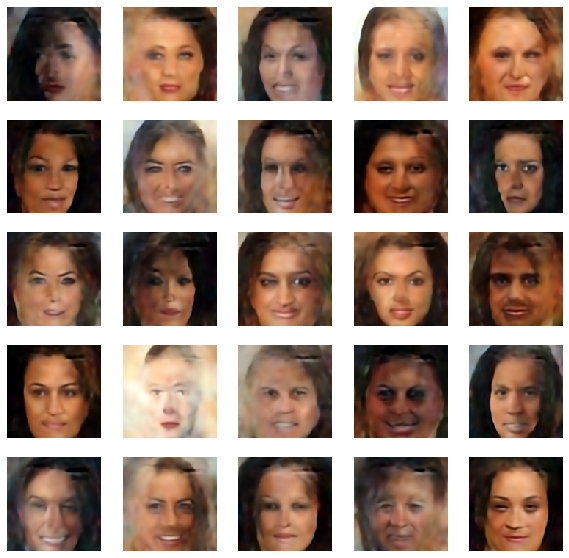

In [105]:
testnoise = 2*np.random.rand(25,lat_size)-1
testresult = discriminator(generator(testnoise,training=False),training=False)

Fig= plt.figure(figsize=(10,10))

for ts in range(25):
    FFS = Fig.add_subplot(5,5,ts+1)
    FFS.imshow(testresult[ts,:,:,:])
    plt.axis('off')

Text(0, 0.5, 'learning rate')

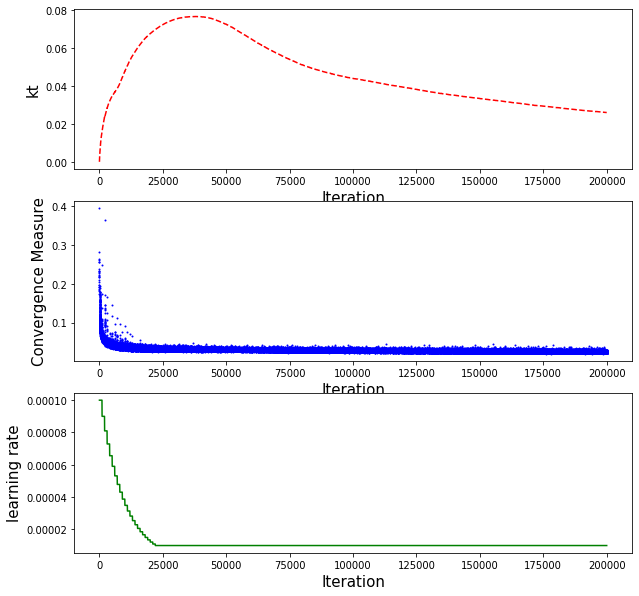

In [7]:
Figkm = plt.figure(figsize=(10,10))
axkm1 = Figkm.add_subplot(3,1,1)
axkm1.plot(kttot[1:],'r--')
axkm1.set_xlabel('Iteration', Fontsize = 15)
axkm1.set_ylabel('kt',Fontsize=15)
axkm2 = Figkm.add_subplot(3,1,2)
axkm2.plot(Mtot[1:],'b.',Markersize=2)
axkm2.set_xlabel('Iteration', Fontsize = 15)
axkm2.set_ylabel('Convergence Measure',Fontsize=15)
axkm2 = Figkm.add_subplot(3,1,3)
axkm2.plot(lrmat[:],'g',Markersize=2)
axkm2.set_xlabel('Iteration', Fontsize = 15)
axkm2.set_ylabel('learning rate',Fontsize=15)

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


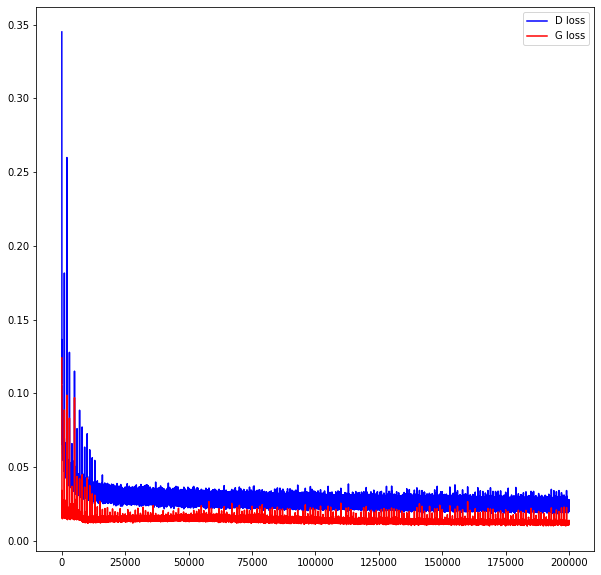

In [8]:
figdg = plt.figure(figsize = (10,10))
axdg = figdg.add_subplot(1,1,1)
axdg.plot(Dlossmat[1:],'b')
axdg.plot(Glossmat[1:],'r')
axdg.legend(['D loss', 'G loss'])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

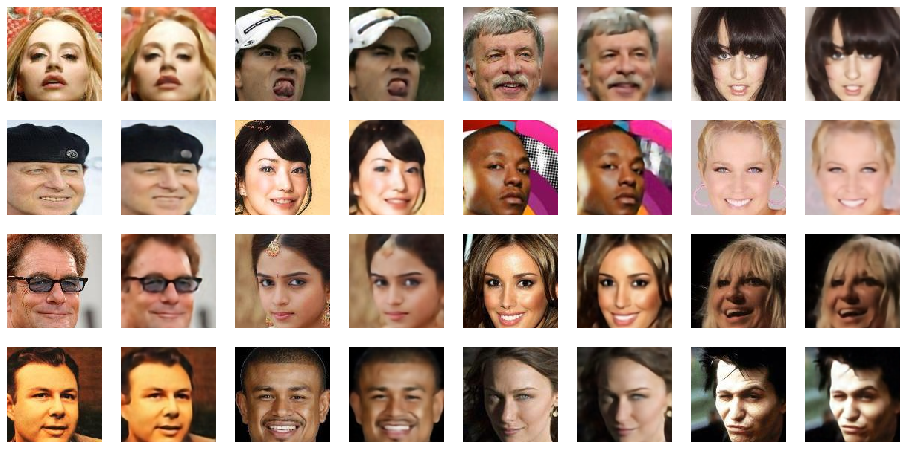

In [9]:
disc_testnum = np.random.choice(face.shape[0],batch_size,replace=False)
disctest = face[disc_testnum,:,:,:]

disc_pic = discriminator(disctest,training=False)

figdisc= plt.figure(figsize=(16,8))
for dts in range(batch_size*2):
    dtf = figdisc.add_subplot(4,8,dts+1)
    if dts%2 == 0:
        dtf.imshow(disctest[int(dts/2),:,:,:])
    elif dts%2 == 1:
        dtf.imshow(disc_pic[int((dts)/2),:,:,:])            
    plt.axis('off')

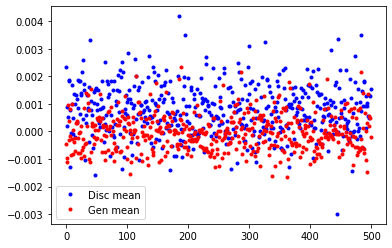

In [10]:
pickmean = np.random.choice(face.shape[0],500,replace=False)
disc_meantest = face[pickmean,:,:,:]-discriminator(face[pickmean,:,:,:],training=False)

latentmean = np.random.uniform(low=0, high=1, size=[500,lat_size])
gen_mean_tmp = generator(latentmean,training=False)
gen_meantest = gen_mean_tmp-discriminator(gen_mean_tmp,training=False)

disc_mean = np.mean(np.mean(np.mean(disc_meantest,axis = 1),axis=1),axis=1)
gen_mean = np.mean(np.mean(np.mean(gen_meantest,axis = 1),axis=1),axis=1)
plt.plot(disc_mean,'b.')
plt.plot(gen_mean,'r.')
plt.legend(['Disc mean','Gen mean'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


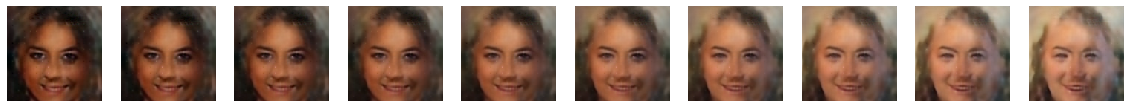

In [141]:
samp_num = 10
lat_for_interp1 = 2*np.random.rand(lat_size)-1
lat_for_interp2 = 2*np.random.rand(lat_size)-1

lat_for_interp1 = np.reshape(lat_for_interp1,[1,lat_size])
lat_for_interp2 = np.reshape(lat_for_interp2,[1,lat_size])

interp_tmp = np.linspace(0,1,num=samp_num)

for i in interp_tmp:
    L = (1-i)*lat_for_interp1 + i*lat_for_interp2
    if i==0:
        Latmat = L
    else:
        Latmat = np.append(Latmat,L,axis=0)
        
int_image = generator(Latmat,training=False)

intfig= plt.figure(figsize=(20,25))

for ipnum in range(samp_num):
    intsubp = intfig.add_subplot(1,samp_num,ipnum+1)
    intsubp.imshow(int_image[ipnum,:,:,:])
    plt.axis('off')